In [15]:
import os

import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [2]:
def find_feature_extraction_files(directory):
    """
    Searches for 'feature_extraction.csv' files within each subdirectory of a given directory.
    
    Args:
    directory (str): The path to the directory to search within.
    
    Returns:
    list: A list of full paths to each 'feature_extraction.csv' file found.
    """
    csv_files = []
    # Walk through each subdirectory in the provided directory
    for root, dirs, files in os.walk(directory):
        # Check if 'feature_extraction.csv' is in the files list
        if 'feature_extraction.csv' in files:
            # Construct full path and add to the list
            full_path = os.path.join(root, 'feature_extraction.csv')
            csv_files.append(full_path)
            
    return csv_files


In [16]:
def find_feature_extraction_files(directory):
    """
    Searches for 'feature_extraction.csv' files within each subdirectory of a given directory, 
    excluding those subdirectories whose names contain '_augmented'.
    
    Args:
    directory (str): The path to the directory to search within.
    
    Returns:
    list: A list of full paths to each 'feature_extraction.csv' file found, excluding those in '_augmented' folders.
    """
    csv_files = []
    # Walk through each subdirectory in the provided directory
    for root, dirs, files in os.walk(directory):
        # Skip directories that contain '_augmented' in their names
        if '_augmented' in root:
            continue
        
        # Check if 'feature_extraction.csv' is in the files list
        if 'feature_extraction.csv' in files:
            # Construct full path and add to the list
            full_path = os.path.join(root, 'feature_extraction.csv')
            csv_files.append(full_path)
            
    return csv_files

In [17]:
def read_csv(data_file_path):
    
    df_read_file = pd.read_csv(data_file_path)
    df_Acc = df_read_file.loc[:, :"Label"]
    X_data = df_Acc.to_numpy()
    
    y_data = df_read_file.loc[:,"Label"]
    y_data = np.around(y_data, decimals=0)

    return X_data, y_data

def normalize_positions(data):
    posX_columns = [0] + list(range(4, 22))   # Adjusted for 0-based indexing: Columns 0 and 4 to 21 for PosX normalization
    posY_columns = [1] + list(range(22, 39))  # Adjusted for 0-based indexing: Columns 1 and 22 to 38 for PosY normalization
    
    # Normalize PosX columns
    data[:, posX_columns] = data[:, posX_columns] / 1920
    # Normalize PosY columns
    data[:, posY_columns] = data[:, posY_columns] / 1080
            
    return data

def handle_indices(data, indexes_of_labels, label_value=0, label_col=0):
    # Ensure data is a single column NumPy array
    data = data[:, label_col] if data.ndim > 1 else data
    

    found_indexes = set(indexes_of_labels)  # Using a set to avoid duplicates

    if indexes_of_labels:
        # Handling '0' label exactly 3 lines before the first label
        first_label_index = indexes_of_labels[0]
        target_index_before_first = first_label_index - 3
        if 0 <= target_index_before_first < len(data) and data[target_index_before_first] == label_value:
            found_indexes.add(target_index_before_first)

        # Handling '0' label exactly 3 lines after the last label
        last_label_index = indexes_of_labels[-1]
        target_index_after_last = last_label_index + 3
        if 0 <= target_index_after_last < len(data) and data[target_index_after_last] == label_value:
            found_indexes.add(target_index_after_last)

        # Handling the '0' label in the middle between given label indices
        for i in range(len(indexes_of_labels) - 1):
            start_index = indexes_of_labels[i]
            end_index = indexes_of_labels[i + 1]
            middle_index = (start_index + end_index) // 2
            if data[middle_index] == label_value:
                found_indexes.add(middle_index)

    # Convert set to a sorted list
    sorted_indexes = sorted(found_indexes)
    
    return sorted_indexes


def lstm_data_transform(x_data, y_data, keys, num_steps=6):
    X, y = list(), list()
    
    # Loop over the provided end indexes
    for end_ix in keys:
        # Calculate the start index for the current window
        start_ix = end_ix - num_steps + 1
        
        # Ensure the start index is not negative
        if start_ix < 0:
            continue
        
        # Get a sequence of data for x
        seq_X = x_data[start_ix:end_ix + 1, :-1]
        
        # Check if the sequence has the correct number of steps
        if seq_X.shape[0] == num_steps:

            # Append the sequence and target to the lists
            X.append(seq_X)
    
    # Convert the lists to numpy arrays
    x_array = np.array(X)
    y_array = np.array([0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0])
    
    return x_array, y_array

In [18]:
def extract_relevant_rows(csv_path):
    x_array, y_array = read_csv(csv_path)
    
    # Normalize the position columns
    x_array = normalize_positions(x_array)

    # Define the values to check
    values_to_check = {1, 2, 3, 4, 5}

    # Find the indexes of values in y_array that are in values_to_check
    indexes_of_labels = [index for index, value in enumerate(y_array) if value in values_to_check]

    sorted_indices = handle_indices(y_array, indexes_of_labels)
    
    # print('Sorted indices: ', sorted_indices)
    
    if len(sorted_indices) <= 10:
        
        print(csv_path)

    x_data, y_data = lstm_data_transform(x_array, y_array, sorted_indices, num_steps=6)

    return x_data, y_data


In [19]:
# Example of how to call this function for one CSV file
file_paths = find_feature_extraction_files('Frames')

print(len(file_paths))


347


In [20]:
num_of_steps = 6
num_of_input_signals = 55

X_data = np.empty([0, num_of_steps, num_of_input_signals], dtype="float32")
y_data = np.empty([0], dtype="float32")

for file_path in file_paths:
    
    data, labels = extract_relevant_rows(file_path)
    
    # print(labels.shape)
    
    X_data = np.append(X_data, data[:], axis=0)
    
    # print(labels.shape)
    y_data = np.append(y_data, labels, axis=0)
    
print(X_data.shape)   # This should show (x, 6, 55) if  everything is correctly configured
print(y_data.shape)  


(3817, 6, 55)
(3817,)


In [21]:
def one_hot_encode_labels(y_data):
    encoder = OneHotEncoder(sparse_output=False)
    y_data_encoded = encoder.fit_transform(y_data)

    return y_data_encoded

In [22]:
# # # One-hot encode the labels
# final_labels_encoded = one_hot_encode_labels(y_data.reshape(-1,1))

final_labels_encoded = keras.utils.to_categorical(y_data, num_classes=6)

print(final_labels_encoded)

# print('x_data shape:', final_data.shape)
print('y_data shape:', final_labels_encoded.shape)


[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]]
y_data shape: (3817, 6)


In [23]:
# splits = custom_k_fold_split(x_data_flat, y_data_flat, n_splits=5, window_size=num_of_steps)

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42)
    
for train_index, test_index in sss.split(X_data, y_data): 
    X_train_pre, X_test = X_data[train_index], X_data[test_index] 
    y_train_pre, y_test = final_labels_encoded[train_index], final_labels_encoded[test_index] 
    
for train_index, val_index in sss.split(X_train_pre, y_train_pre):
    X_train, X_val = X_train_pre[train_index], X_train_pre[val_index] 
    y_train, y_val = y_train_pre[train_index], y_train_pre[val_index] 

# y_test.resize(y_test.shape[0],1,y_test.shape[1])
# y_train.resize(y_train.shape[0],1, y_train.shape[1])
# y_val.resize(y_val.shape[0],1, y_val.shape[1])
    
print("Train data shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("------------------------------------\n")
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)
print("------------------------------------\n")
print("Validation data shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)


Train data shape: (3091, 6, 55)
Train labels shape: (3091, 6)
------------------------------------

Test data shape: (382, 6, 55)
Test labels shape: (382, 6)
------------------------------------

Validation data shape: (344, 6, 55)
Validation labels shape: (344, 6)


In [13]:
from tensorflow.keras.optimizers import Adam, RMSprop 

from tensorflow.keras.regularizers import l1_l2, l2

########################################################
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, InputLayer, Reshape, TimeDistributed, Dropout, BatchNormalization, Bidirectional

# Define the CNN-LSTM model
model = keras.Sequential()

# Input layer - assumes input_shape is defined appropriately for your data
# For example, input_shape could be (sequence_length, features_per_step)
model.add(InputLayer(shape=(6, 55)))
# Batch Normalization layer before LSTM to normalize inputs
model.add(BatchNormalization())

# Adding a Bidirectional LSTM layer with L2 regularization
# Note: Adjust the `l2` regularization strength as needed
model.add(Bidirectional(LSTM(100, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l1_l2(l1=1e-5, l2=0.001))))
# Adding another Bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, return_sequences=False, dropout=0.3,recurrent_dropout=0.3)))

# Output layer - assuming a classification problem with 6 classes
model.add(Dense(6, activation='softmax'))


###########################################################
# model.add(InputLayer(shape=(6, 55)))
# model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
# model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
# 
# # Ensure the kernel size is smaller than the sequence length
# model.add(Conv1D(32, 5, activation='relu'))
# model.add(MaxPooling1D(pool_size=1))  # Reduce the sequence length by a factor of 2
# model.add(Conv1D(16, 2, activation='relu'))
# 
# # Since MaxPooling1D and Conv1D layers have reduced the sequence length, we need to adjust for the LSTM layer
# model.add(LSTM(16, activation='tanh', return_sequences=True))
# model.add(Dropout(0.5))
# 
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(6, activation='softmax'))

In [12]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 6, 55)          │           220 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 6, 200)         │       124,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,206 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 367,026 (1.40 MB)

 Trainable params: 366,916 (1.40 MB)

 Non-trainable params: 110 (440.00 B)

In [ ]:
import datetime

now = datetime.datetime.now()

In [39]:
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau


es_callback = EarlyStopping(monitor='val_loss', mode='min', patience=50, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15)

In [40]:
from torch.utils.benchmark import timer

# fit the keras model on the dataset0
startTime = timer()
history = model.fit(X_train, y_train, epochs=245, callbacks=[es_callback, reduce_lr], validation_data=(X_val, y_val), batch_size=32, verbose=1)#, class_weight=class_weight_dict)

endTime = timer()
print("Model trained in {:f}s.".format(endTime - startTime))
print("This is {:f}min.".format((endTime - startTime)/60))

Epoch 1/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5291 - loss: 1.3532 - val_accuracy: 0.5373 - val_loss: 1.7586 - learning_rate: 0.0010
Epoch 2/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6081 - loss: 0.9909 - val_accuracy: 0.5617 - val_loss: 1.1284 - learning_rate: 0.0010
Epoch 3/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6227 - loss: 0.9045 - val_accuracy: 0.6118 - val_loss: 0.9127 - learning_rate: 0.0010
Epoch 4/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6396 - loss: 0.8574 - val_accuracy: 0.6414 - val_loss: 0.8212 - learning_rate: 0.0010
Epoch 5/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6422 - loss: 0.8271 - val_accuracy: 0.6508 - val_loss: 0.7831 - learning_rate: 0.0010
Epoch 6/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6552 - loss: 0.7939 - val_accuracy: 0.6589 - val_loss: 0.7461 - learning_rate: 0.0010
Epoch 7/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6640 - l

In [9]:
import datetime
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, InputLayer, Reshape, TimeDistributed, Dropout, BatchNormalization, Bidirectional
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau

# Configuration to run training multiple times and save best model
best_loss = float('inf')
best_model = None
best_history = None

for run in range(9):
    print(f"Running training iteration {run+1}")

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42 + run)
    
    for train_index, test_index in sss.split(X_data, y_data): 
        X_train_pre, X_test = X_data[train_index], X_data[test_index]
        y_train_pre, y_test = final_labels_encoded[train_index], final_labels_encoded[test_index]

    for train_index, val_index in sss.split(X_train_pre, y_train_pre):
        X_train, X_val = X_train_pre[train_index], X_train_pre[val_index]
        y_train, y_val = y_train_pre[train_index], y_train_pre[val_index]

    # Define and compile the model
    model = keras.Sequential([
        InputLayer(shape=(6, 55)),
        BatchNormalization(),
        Bidirectional(LSTM(100, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l1_l2(l1=1e-5, l2=0.001))),
        Bidirectional(LSTM(100, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)),
        Dense(6, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Set up callbacks
    es_callback = EarlyStopping(monitor='val_loss', mode='min', patience=50, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=15)

    # Train the model and save the history
    history = model.fit(X_train, y_train, epochs=250, callbacks=[es_callback, reduce_lr], validation_data=(X_val, y_val), batch_size=32, verbose=1)

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    # Update best model if current model is better
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model
        best_history = history
        model.save('best_model.keras')
        print("Best model updated")

print(f"Best Validation Loss achieved: {best_loss}")

# # Load the best model
# best_model = load_model('best_model.h5')

Running training iteration 1
Epoch 1/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4879 - loss: 1.4510 - val_accuracy: 0.5320 - val_loss: 1.8271 - learning_rate: 0.0010
Epoch 2/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5959 - loss: 1.1049 - val_accuracy: 0.5058 - val_loss: 1.4117 - learning_rate: 0.0010
Epoch 3/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6080 - loss: 1.0005 - val_accuracy: 0.5988 - val_loss: 1.1047 - learning_rate: 0.0010
Epoch 4/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6209 - loss: 0.9489 - val_accuracy: 0.5901 - val_loss: 1.0381 - learning_rate: 0.0010
Epoch 5/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6341 - loss: 0.8769 - val_accuracy: 0.6134 - val_loss: 0.9516 - learning_rate: 0.0010
Epoch 6/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6449 - loss: 0.8740 - val_accuracy: 0.5814 - val_loss: 0.9513 - learning_rate: 0.0010
Epoch 7/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
Shape of predictions: (382, 6)
Shape of y_test: (382, 6)
Shape of predictions after reshaping: (382, 6)
Shape of y_test after reshaping: (382, 6)
Shape of predicted_classes: (382,)
Shape of true_classes: (382,)


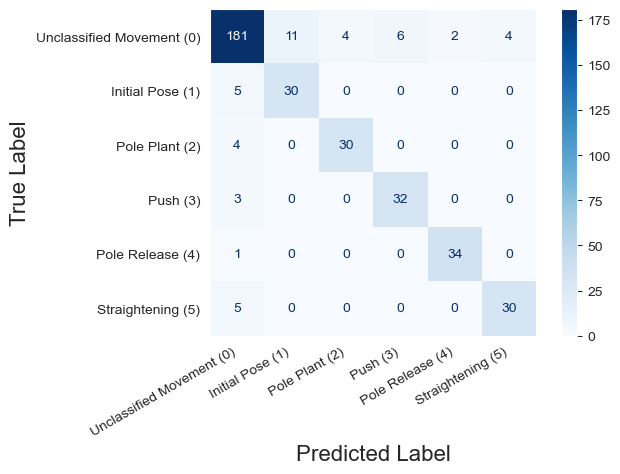

In [24]:
# Predict on the test data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = keras.models.load_model('Results/xcs_model.keras')

best_model = model

# Assuming X_test and y_test are already defined and preprocessed
# Predict on the test data
predictions = best_model.predict(X_test)

# Print the shapes to debug
print(f"Shape of predictions: {predictions.shape}")
print(f"Shape of y_test: {y_test.shape}")

# # Reshape the predictions and y_test to remove the extra dimension
# predictions = predictions.reshape(predictions.shape[0], predictions.shape[2])
# y_test = y_test.reshape(y_test.shape[0], y_test.shape[2])

# Print the shapes to debugs
print(f"Shape of predictions after reshaping: {predictions.shape}")
print(f"Shape of y_test after reshaping: {y_test.shape}")

# Convert predictions and true labels to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Print the shapes to debug
print(f"Shape of predicted_classes: {predicted_classes.shape}")
print(f"Shape of true_classes: {true_classes.shape}")

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Define your custom string labels
labels = ['Unclassified Movement (0)', 'Initial Pose (1)', 'Pole Plant (2)', 'Push (3)', 'Pole Release (4)', 'Straightening (5)']

# Display the confusion matrix with string labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# Display the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
ax = disp.plot(cmap=plt.cm.Blues)
# Remove grid lines
ax.ax_.grid(False)  # Turn off the grid lines

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45)
# Optionally, adjust font size
plt.gcf().autofmt_xdate()  # Adjust layout to make room for diagonal labels
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)

# Save the figure as an EPS file
plt.savefig('confusion_matrix.eps', format='eps', bbox_inches='tight')
plt.show()

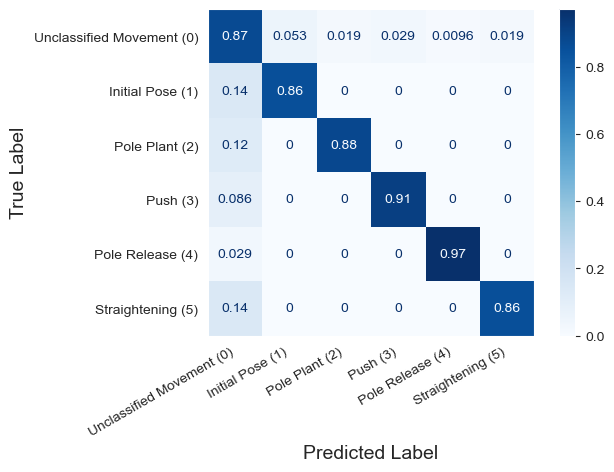

In [25]:
# Generate the normalized confusion matrix
cm = confusion_matrix(true_classes, predicted_classes, normalize='true')

# Define your custom string labels
labels = ['Unclassified Movement (0)', 'Initial Pose (1)', 'Pole Plant (2)', 'Push (3)', 'Pole Release (4)', 'Straightening (5)']

# Display the confusion matrix with string labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# Display the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
ax = disp.plot(cmap=plt.cm.Blues)
# Remove grid lines
ax.ax_.grid(False)  # Turn off the grid lines

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45)
# Optionally, adjust font size
plt.gcf().autofmt_xdate()  # Adjust layout to make room for diagonal labels
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

# Save the figure as an EPS file
plt.savefig('confusion_matrix_normalized.eps', format='eps', bbox_inches='tight')
plt.show()

In [26]:
# Calculate overall accuracy from the confusion matrix
overall_accuracy = np.trace(cm) / np.sum(cm)
print(f"Overall Accuracy: {overall_accuracy: .2f}%")

# Generate the raw confusion matrix (for accuracy calculation)
cm_raw = confusion_matrix(true_classes, predicted_classes)

# Calculate overall accuracy from the raw confusion matrix
overall_accuracy = np.trace(cm_raw) / np.sum(cm_raw)
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

Overall Accuracy:  0.89%
Overall Accuracy: 88.22%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 1200x600 with 0 Axes>

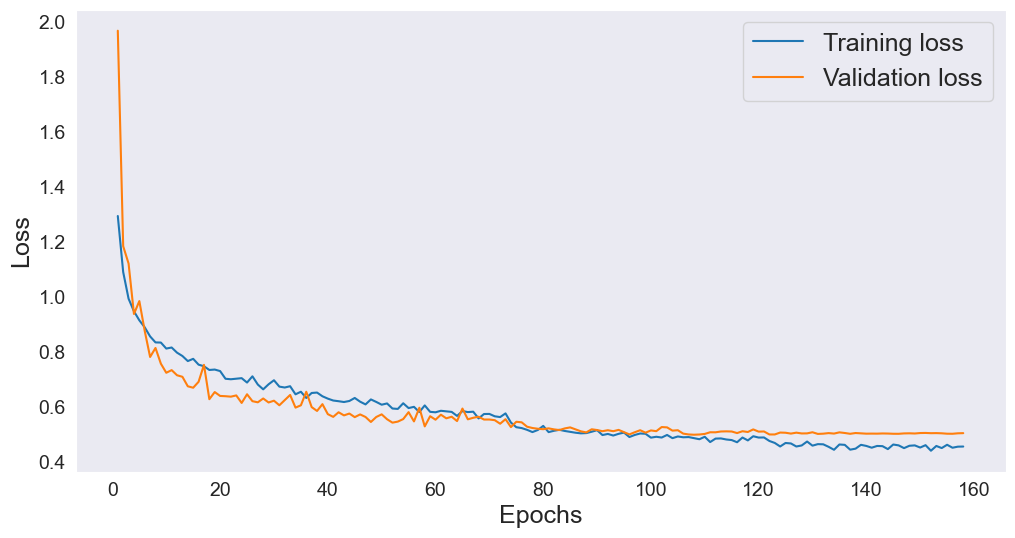

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


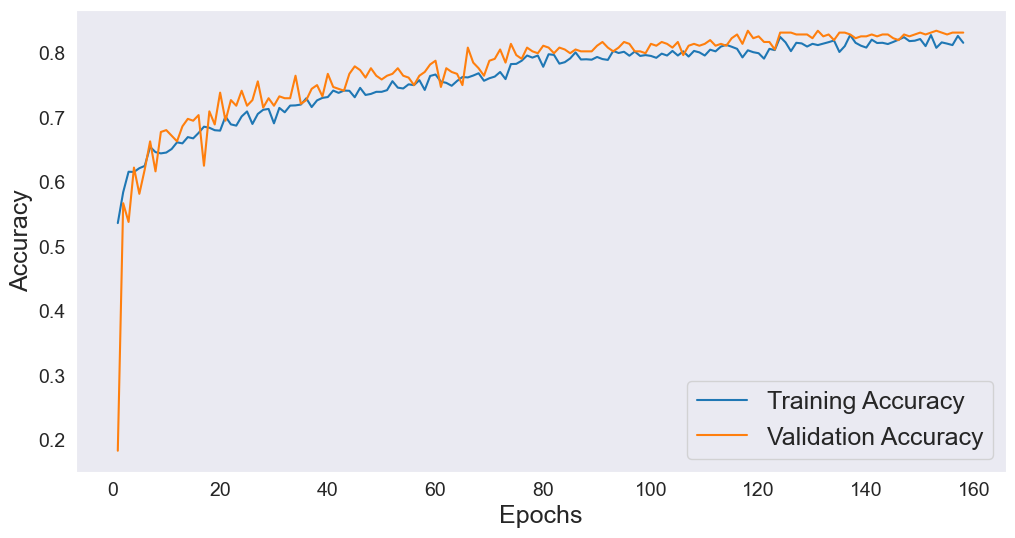

In [16]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from your model.fit() call
# Extracting the data from the history object
loss = best_history.history['loss']
val_loss = best_history.history['val_loss']
accuracy = best_history.history.get('accuracy')
val_accuracy = best_history.history.get('val_accuracy')

# Creating the plots0
epochs = range(1, len(loss) + 1)

# Assuming 'epochs', 'loss', 'val_loss', 'accuracy', and 'val_accuracy' are defined
plt.figure(figsize=(12, 6))

# Plotting training and validation loss in a separate figure
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
#plt.title('Training and Validation Loss')
plt.legend(fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)  # Turn off the grid
plt.savefig('best_training_loss.eps', format='eps', bbox_inches='tight')  # Save if needed
plt.show()

# Plotting training and validation accuracy in a separate figure
if accuracy and val_accuracy:
    plt.figure(figsize=(12, 6))  # Adjust figure size as needed
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    # plt.title('Training and Validation Accuracy')
    plt.legend(fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(False)  # Turn off the grid
    plt.savefig('best_training_accuracy.eps', format='eps', bbox_inches='tight')  # Save if needed
    plt.show()


In [15]:
best_model.save('xcs_model.keras')

In [13]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

model = keras.models.load_model('Results/xcs_model_aug_128.keras')

# Schritt 3: Vorhersagen generieren
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Schritt 4: Konfusionsmatrix berechnen
cm = confusion_matrix(true_classes, y_pred_classes)
print('Confusion Matrix:\n', cm)

# Schritt 5: Präzision, Recall und F1-Score berechnen
precision = precision_score(true_classes, y_pred_classes, average=None)
recall = recall_score(true_classes, y_pred_classes, average=None)
f1 = f1_score(true_classes, y_pred_classes, average=None)

print('Precision per class:', precision)
print('Recall per class:', recall)
print('F1-Score per class:', f1)

# Optional: Durchschnittliche Werte berechnen
precision_avg = precision_score(true_classes, y_pred_classes, average='macro')
recall_avg = recall_score(true_classes, y_pred_classes, average='macro')
f1_avg = f1_score(true_classes, y_pred_classes, average='macro')

print('Average Precision:', precision_avg)
print('Average Recall:', recall_avg)
print('Average F1-Score:', f1_avg)

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Confusion Matrix:
 [[972  25  22   8   0  14]
 [ 21 152   1   0   0   0]
 [ 19   0 154   0   0   0]
 [  5   0   0 169   0   0]
 [  5   0   0   0 169   0]
 [  5   0   0   0   0 168]]
Precision per class: [0.94644596 0.85875706 0.8700565  0.95480226 1.         0.92307692]
Recall per class: [0.93371758 0.87356322 0.89017341 0.97126437 0.97126437 0.97109827]
F1-Score per class: [0.94003868 0.86609687 0.88       0.96296296 0.98542274 0.94647887]
Average Precision: 0.9255231168983583
Average Recall: 0.9351802015957146
Average F1-Score: 0.9301666879239304


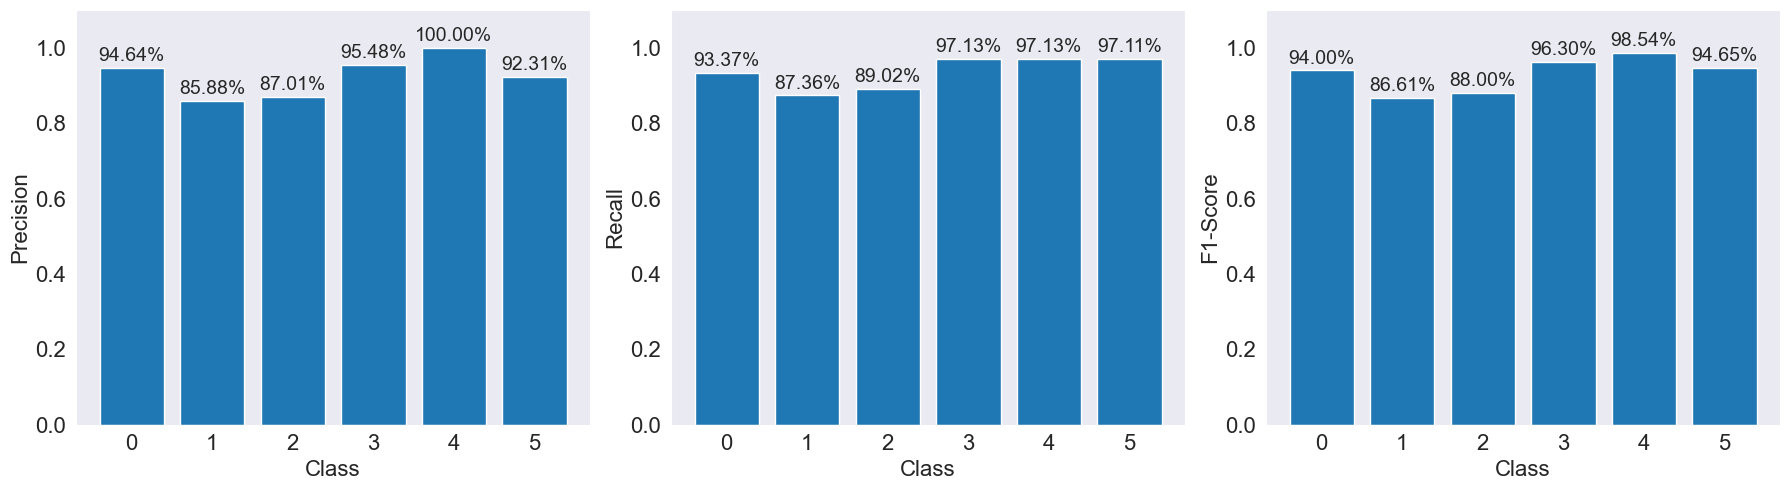

In [11]:
# Schritt 7: Ergebnisse visualisieren
import matplotlib.pyplot as plt

metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

metrics_avg = {
    'Average Precision': precision_avg,
    'Average Recall': recall_avg,
    'Average F1-Score': f1_avg
}

# Balkendiagramme für jede Metrik
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (metric_name, metric_values) in zip(axes, metrics.items()):
    bars = ax.bar(range(len(metric_values)), metric_values)
    #ax.set_title(metric_name)
    ax.set_xlabel('Class', fontsize=16)
    ax.set_ylabel(metric_name, fontsize=16)
    ax.set_xticks(range(len(metric_values)))
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_ylim(0.0, 1.1)
    ax.grid(False)
    # Prozentzahlen über die Balken schreiben
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 2),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=14)

plt.tight_layout()
plt.show()

# # Durchschnittswerte visualisieren
# plt.figure(figsize=(8, 5))
# bars = plt.bar(metrics_avg.keys(), metrics_avg.values(), color='lightgreen')
# plt.title('Average Metrics')
# plt.ylabel('Score')
# # Prozentzahlen über die Balken schreiben
# for bar in bars:
#     height = bar.get_height()
#     plt.annotate(f'{height:.2%}',
#                  xy=(bar.get_x() + bar.get_width() / 2, height),
#                  xytext=(0, 3),  # 3 points vertical offset
#                  textcoords="offset points",
#                  ha='center', va='bottom')
# 
# plt.show()

In [12]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

# Funktion zum Erstellen von Gleitfenstern und zugehörigen Rahmenindizes
def create_windows(data, window_size, step_size):
    windows = []
    indices = []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
        indices.append(end - 1)  # Der letzte Index des Fensters
    return np.array(windows), indices

# Vortrainiertes Keras-Modell laden
model_path = 'Results/xcs_model_aug_128.keras'  # Pfad zur Modell-Datei
model = keras.models.load_model(model_path)

# CSV-Datei laden
csv_path = 'Frames/1_Petzold Luca_lq/feature_extraction.csv'  # Pfad zur CSV-Datei
data = pd.read_csv(csv_path)

# Annahme, dass die letzte Spalte für die Vorhersage nicht benötigt wird
X = data.iloc[:, :-1].values  # In ein Numpy-Array konvertieren

normalized_X = normalize_positions(X)

# Gleitfenster erstellen
window_size = 6  # Anzahl der Zeitstufen pro Fenster
step_size = 1    # Schrittgröße für das Gleitfenster
windows, indices = create_windows(normalized_X, window_size, step_size)

# Vorhersagen für jedes Fenster machen
predictions = model.predict(windows)

# Annahme, dass die Vorhersagen Wahrscheinlichkeiten für jede Klasse sind
predicted_classes = np.argmax(predictions, axis=1)

# Ein Array zum Halten der Rahmenvorhersagen erstellen
frame_predictions = np.zeros(len(X), dtype=int)

# Vorhersagen den letzten Rahmen jedes Fensters zuordnen
for idx, pred_class in zip(indices, predicted_classes):
    frame_predictions[idx] = pred_class

# Anfangsrahmen und letzte Rahmen behandeln
frame_predictions[:indices[0]] = predicted_classes[0]
frame_predictions[indices[-1]+1:] = predicted_classes[-1]

# Verteilung der vorhergesagten Klassen überprüfen
unique, counts = np.unique(frame_predictions, return_counts=True)
print("Klassenverteilung in den Vorhersagen:", dict(zip(unique, counts)))

# Visuelle Inspektion der ersten Vorhersagen
# print("Erste Rahmenvorhersagen:", frame_predictions[:20])

# DataFrame für die vorhergesagten Klassen erstellen
df_predictions = pd.DataFrame(frame_predictions, columns=['Predicted Class'])
# print(df_predictions.T)  # Transponieren, um das gewünschte Ausgabeformat zu erreichen

# Optional: in CSV speichern
# df_predictions.to_csv('predicted_classes.csv', index=False)

# Vorhersagen für das Plotten in 0 und 1 konvertieren
binary_predictions = np.zeros((len(X), predictions.shape[1]))
for i, pred_class in enumerate(frame_predictions):
    binary_predictions[i, pred_class] = 1

# Binäre Vorhersagen im Zeitverlauf für jede Klasse in separaten Subplots plotten
time_steps = np.arange(len(X))  # Ein Array von Zeitstufen erstellen



4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
Klassenverteilung in den Vorhersagen: {0: 72, 1: 2, 2: 7, 3: 10, 4: 11, 5: 9}


In [13]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Function to create sliding windows and corresponding frame indices
def create_windows(data, window_size, step_size):
    windows = []
    indices = []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
        indices.append(end - 1)  # The last index of the window
    return np.array(windows), indices

# Load the pre-trained Keras model
model_path = 'Results/xcs_model_aug_128.keras'  # Path to the model file
model = keras.models.load_model(model_path)

# Load the CSV file
csv_path = 'Frames/1_Petzold Luca_lq/feature_extraction.csv'  # Path to the CSV file
data = pd.read_csv(csv_path)

# Assuming the last column is not required for the prediction
X = data.iloc[:, :-1].values  # Convert to numpy array

normalized_X = normalize_positions(X)


# Create sliding windows
window_size = 6  # Number of time steps per window
step_size = 1    # Step size for the sliding window
windows, indices = create_windows(normalized_X, window_size, step_size)

# Make predictions on each window
predictions = model.predict(windows)

# Create an array to hold the frame predictions
frame_predictions = np.zeros((len(normalized_X), predictions.shape[1]))

# Assign predictions to the last frames of each window
for idx, prediction in zip(indices, predictions):
    frame_predictions[idx] = prediction

# Handle the first few frames (fill with the first prediction)
for i in range(indices[0]):
    frame_predictions[i] = predictions[0]
# Handle the last few frames (fill with the last prediction)
for i in range(indices[-1] + 1, len(normalized_X)):
    frame_predictions[i] = predictions[-1]

# Check the distribution of predicted classes
unique, counts = np.unique(np.argmax(frame_predictions, axis=1), return_counts=True)
print("Class distribution in predictions:", dict(zip(unique, counts)))

# Visual inspection of the first few predictions
# print("First few frame predictions:", frame_predictions[:20])

# Create a DataFrame for the predicted classes with confidence scores
df_predictions = pd.DataFrame(frame_predictions, columns=[f'Class {i} Confidence' for i in range(predictions.shape[1])])
# print(df_predictions.head().T)  # Transpose to match the desired output format

print(len(df_predictions))

# Optionally, save to CSV
# df_predictions.to_csv('predicted_classes_with_confidence.csv', index=False)

# Plotting the confidence of predictions over time for each class in separate subplots
time_steps = np.arange(len(normalized_X))  # Create an array of time steps

y = data.iloc[:, -1].values   # Labels

# Find indices where labels are not zero
non_zero_label_indices = np.where(y != 0)[0]

print(df_predictions.iloc[non_zero_label_indices-1])

# print("Labels at indices:", y[non_zero_label_indices])
# print("Labels at indices +1:", y[non_zero_label_indices + 1])

1/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/stepWARNING:tensorflow:6 out of the last 68 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000021FDAF4FBA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step
Class distribution in predictions: {0: 72, 1: 2, 2: 7, 3: 10, 4: 11, 5: 9}
111
    Class 0 Confidence  Class 1 Confidence  Class 2 Confidence  \
42            0.237300        7.625784e-01        1.19

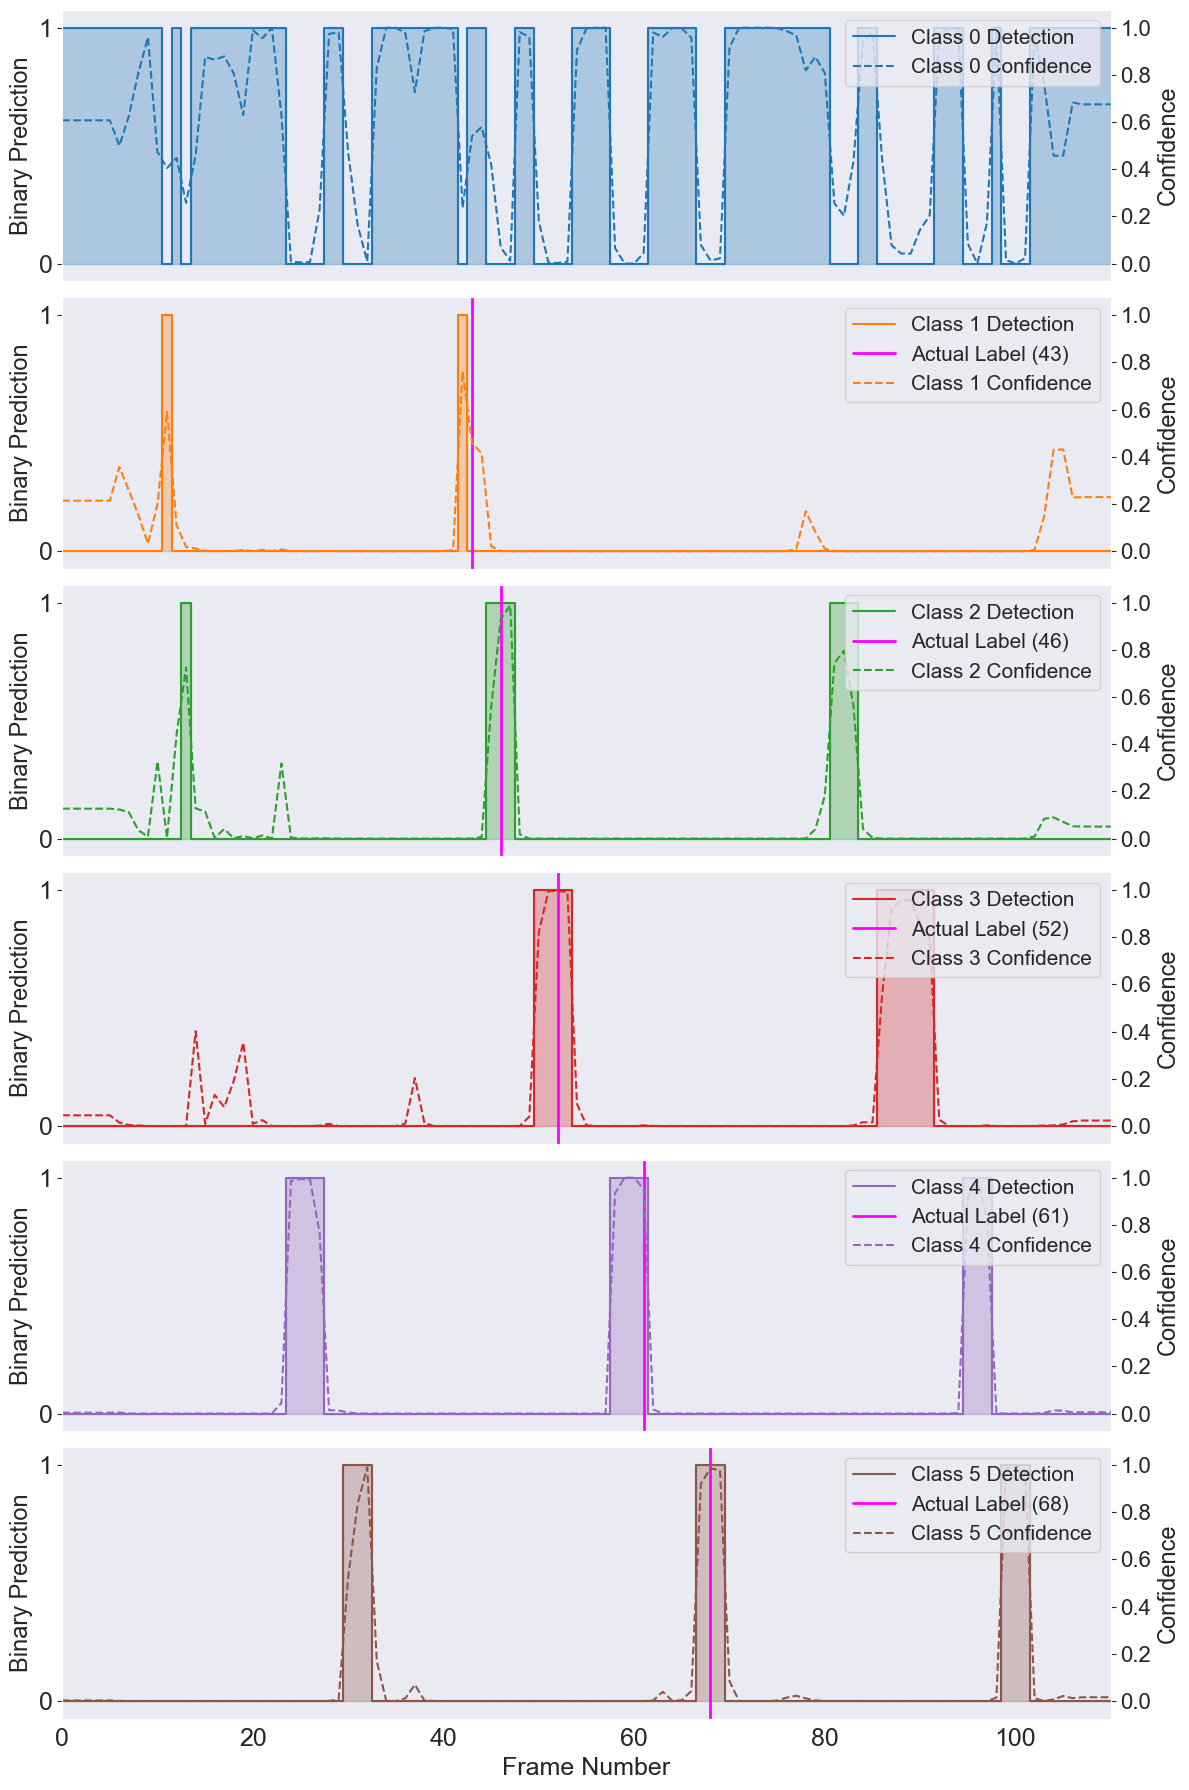

In [19]:
# Define a color map for different classes
colors = plt.colormaps['tab10']

num_classes = predictions.shape[1]
fig, axes = plt.subplots(num_classes, 1, figsize=(12, 3 * num_classes), sharex=True)

for class_idx in range(num_classes):
    ax = axes[class_idx]
    ax.step(time_steps, binary_predictions[:, class_idx], label=f'Class {class_idx} Detection', color=colors(class_idx), where='mid')
    ax.fill_between(time_steps, binary_predictions[:, class_idx], step='mid', color=colors(class_idx), alpha=0.3)
    ax.set_ylabel('Binary Prediction', fontsize=17)
    ax.set_ylim(-0.075, 1.075)  # Y-Axis limit slightly below 0 and above 1 for better visibility
    ax.set_yticks([0, 1])
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_xlim(time_steps[0], time_steps[-1])  # Set x-axis limits to the range of time steps
    ax.grid(False)
    
    # # Mark label index for this class only if label is not zero
    # if class_idx > 0:  # Class 0 has no marker
    #     label_index = non_zero_label_indices[y[non_zero_label_indices + 1] == class_idx]
    #     if label_index.size > 0:
    #         ax.axvline(x=label_index[0], color='r', linestyle='--', linewidth=0.8, label='Actual Label')
            
       # Enhancements for the vertical line marking
    if class_idx > 0:
        label_index = non_zero_label_indices[class_idx - 1]
        if label_index.size > 0:
            # Improved visibility of the vertical line
            ax.axvline(x=label_index, color='magenta', linestyle='-', linewidth=2, label=f'Actual Label ({label_index})')
            # Adding a text annotation
            #ax.text(label_index, ax.get_ylim()[1] * 0.9, f'Frame {label_index}', rotation=0, verticalalignment='center', color='magenta', fontsize=16)

    # Create a twin y-axis to plot confidence levels
    ax2 = ax.twinx()
    ax2.plot(time_steps, frame_predictions[:, class_idx], label=f'Class {class_idx} Confidence', color=colors(class_idx), linestyle='--') #, where='mid')
    ax2.set_ylabel('Confidence', fontsize=17)
    ax2.set_ylim(-0.075, 1.075)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.grid(False)

    # Combine legends
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=15)

axes[-1].set_xlabel('Frame Number', fontsize=18)

plt.tight_layout()
#plt.show()

plt.savefig('prediction_comp.png', format='png', bbox_inches='tight')  # Save if needed)